In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

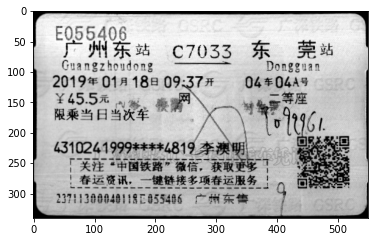

In [10]:
att_img = "tickets/0022.bmp"
att_img = cv2.imread(att_img, cv2.IMREAD_GRAYSCALE)

plt.imshow(att_img, cmap='gray')

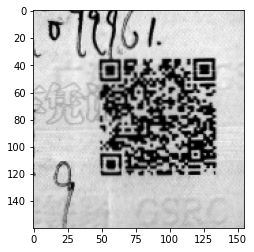

In [11]:
r, c = att_img.shape
crop_img = att_img[int(r*0.5):r-10, int(c*0.7): c-10] # 裁剪比例，右下角约八分之一

plt.imshow(crop_img, cmap='gray')

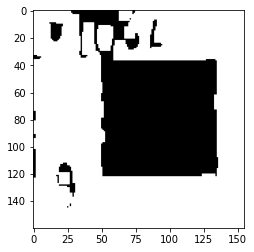

In [12]:
blurred_img = cv2.medianBlur(crop_img, 5)
# 直接对原图二值化 比 对滤波后的图二值化 得到的边更平直，还要滤波吗
_, thres_img = cv2.threshold(crop_img, 80, 255, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8)) # 结构元大小：01、02、22、85、93数字和二维码容易粘连
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel) # 为什么不是闭操作而是开操作

plt.imshow(morphed_img, cmap='gray')

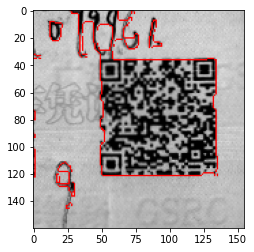

In [13]:
canny = cv2.Canny(morphed_img, 40, 150) 

contour_img = cv2.cvtColor(crop_img, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 1)

plt.imshow(contour_img, cmap='gray')

121.0 1.5707964
36.0 1.5707964
134.0 0.0
-47.0 3.0892327
-133.0 3.1241393
49.0 0.0
34.0 1.5882496
-46.0 3.0717795
122.0 1.553343
-48.0 3.1241393
38.0 1.553343
119.0 1.5882496
135.0 0.017453292
-131.0 3.106686
33.0 1.6057029
117.0 1.6057029
-127.0 3.0717795
1.0 0.0
-129.0 3.0892327
50.0 0.017453292
-45.0 3.054326
137.0 0.034906585
39.0 1.5358897
-42.0 3.0368729
37.0 0.05235988
128.0 1.5009831
126.0 1.5184364
1.0 3.1241393
56.0 0.06981317
30.0 1.6231562
-31.0 2.984513
-43.0 3.0892327
3.0 0.017453292
-44.0 3.0368729
-33.0 3.106686
53.0 0.034906585
59.0 0.10471976
62.0 0.12217305
130.0 1.4835298
42.0 1.5184364
4.0 1.8325957
-29.0 2.9146998
-41.0 3.0019662
3.0 3.106686
115.0 1.6231562
116.0 1.6406095
-40.0 2.9670596
-125.0 3.054326
-32.0 3.0717795
-50.0 3.1241393
5.0 0.034906585
37.0 0.08726646
60.0 0.13962634
61.0 0.20943952
29.0 1.6406095
5.0 1.7802358
-7.0 1.8849555
-28.0 2.8972466
-31.0 2.9321532
35.0 0.034906585
55.0 0.05235988
58.0 0.08726646
70.0 0.20943952
61.0 0.2443461
68.0 0.3665